<a href="https://colab.research.google.com/github/Yuri-Vlasqz/MVP-Sistemas-Inteligentes/blob/main/api/MachineLearning/notebooks/dengue_model_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Treinamento de classificador a partir do dataset pré-processado**

Este notebook contém o treinamento do modelo classsificador de risco de incidência de dengue em um local, baseado em suas condições climáticas.

O Dataset pré-processsado foi gerado no notebook [`dengue_data_exploration.ipynb`](https://colab.research.google.com/drive/1PfF5KW3ropaPlJCg9LGyuChdil2De1KH?usp=sharing) a partir do original, obtido na **2ª edição da Sprint de Previsão de Dengue**.

<div>
<img src="https://sprint.mosqlimate.org/logo-medium.png" width="200" title="IMDC Logo"/>
</div>


**Links sobre desafio e dataset original:**
- *2nd Infodengue-Mosqlimate Dengue Challenge (IMDC)*: https://sprint.mosqlimate.org/
- Instruções para baixar Dataset original: https://sprint.mosqlimate.org/data/


**Links do dataset pré-processado:**
- [`dataset_com_casos_2020_2024.csv`](https://raw.githubusercontent.com/Yuri-Vlasqz/MVP-Sistemas-Inteligentes/refs/heads/main/api/MachineLearning/data/dataset_com_casos_2020_2024.csv)
> arquivo se encontra no repositório
> MVP-Sistemas-Inteligentes\api\MachineLearning\data\

<br>

___
## 🗂️ Estrutura do dataset pré-processado:

O dataset pré-processado condensa um período epidemiológio dos últimos 5 anos (2020 até 2024), de qualquer município brasileiro no qual ocorreu algum caso de dengue (`casos` > 0).

* **Colunas temporais:** `year` e `week`;
* **Colunas de dengue:** `casos` e `taxa_incidencia`;
* **Colunas climáticas:** `temp_min/med/max`, `precip_med`, `rel_humid_med`, `thermal_range` e `rainy_days`;
* **Colunas de geográficas:** `macroregion_code`, `uf_code`, `geocode` e `population`.
* **Coluna *target*:** `risco_dengue`

<br>

### 🎯 Informação da coluna *target* :

A estratificação de risco de ocorrência de dengue em patamares foi baseada na taxa de incidência, calculada abaixo:
$$Taxa\;de\;incidência = \frac{Número\;de\;casos}{População\;local} \times 100\;mil$$
Os valores dos patamares da coluna `risco_dengue` são computados da seguinte forma, conforme informado pela [prefeitura de SP](https://prefeitura.sp.gov.br/w/noticia/municipio-mantem-acoes-intensificadas-de-prevencao):
- **`0 = Baixo risco`**: Incidência de até 100 casos/100 mil habitantes.

- **`1 = Médio risco`**: Incidência acima de 100 até 300 casos/100 mil habitantes.

- **`2 = Alto risco`**: Incidência superior a 300 casos/100 mil habitantes.
> A Organização Mundial da Saúde (OMS) considera que taxas acima de 300 casos por 100 mil habitantes indicam situação epidêmica [[fonte]](https://www.proadess.icict.fiocruz.br/index.php?pag=fic&cod=O04&tab=1).

<br>

---

# 💻 Execução do Notebook abaixo:
---

In [ ]:
# Descomente e rode essa célula se estiver usando notebook localmente!
# !pip install pandas
# !pip install matplotlib
# !pip install scikit-learn
# !pip install seaborn
# !pip install tqdm
# !pip install imbalanced-learn

In [3]:
# configuração para não exibir os warnings
import warnings
warnings.filterwarnings("ignore")
import time

# Imports necessários
from IPython.display import display, Markdown, Latex
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE  # Synthetic Minority Over-sampling Technique
from imblearn.under_sampling import NearMiss  # Undersampling
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, f1_score
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

import pickle

# Pandas
pd.set_option("display.max_columns", None)
# pd.reset_option("display.max_columns")

FINAL_DATASET_LINK = 'https://raw.githubusercontent.com/Yuri-Vlasqz/MVP-Sistemas-Inteligentes/refs/heads/main/api/MachineLearning/data/dataset_com_casos_2020_2024.csv'

> ##### Se ocorrer erro (somente ao rodar localmente) `ImportError: cannot import name '_deprecate_Xt_in_inverse_transform' from 'sklearn.utils.deprecation'`!
> Delete a pasta `~klearn` do local de site-packages deste ambiente virtual anaconda.
>
> Ex.`C:\Users\<seu_usuario>\anaconda3\envs\<seu_ambiente_anaconda>\Lib\site-packages\~klearn`

___
# 📥 Importação do dataset pré-processado
___

In [4]:
df_numerico = pd.read_csv(FINAL_DATASET_LINK)

In [5]:
df_numerico.head()

,year,week,macroregion_code,uf_code,geocode,temp_min,temp_med,temp_max,precip_med,rel_humid_med,thermal_range,rainy_days,population,casos,taxa_incidencia,risco_dengue
0,2020,2,2,27,2709400,22.336300,26.108757,31.704586,0.5010,69.067000,9.368286,5,24953,7,28.052739,0
1,2020,2,2,27,2707701,24.149371,26.807443,30.632171,2.9335,72.190414,6.482800,7,88622,1,1.128388,0
2,2020,2,2,27,2706901,24.070043,26.917100,31.077514,2.6849,72.441900,7.007471,7,35908,1,2.784895,0
3,2020,2,2,27,2706307,22.574771,26.787957,32.937343,0.1469,64.596786,10.362571,5,73148,1,1.367091,0
4,2020,2,2,27,2704005,23.779543,27.358014,32.730043,0.8709,67.288800,8.950500,6,24523,1,4.077805,0


___
## Escolha de variáveis do dataset

In [6]:
# Colunas calculáveis ou com valores obtíveis no WeatherAPI
colunas_minimas = ['week', 'temp_min', 'temp_med', 'temp_max', 'precip_med', 'rel_humid_med', 'thermal_range', 'rainy_days', 'risco_dengue']

# Colunas úteis
# colunas_maximas = ['year', 'week', 'macroregion_code', 'uf_code', 'population',
#                    'temp_min', 'temp_med', 'temp_max', 'precip_med', 'rel_humid_med', 'thermal_range', 'rainy_days', 'risco_dengue']

In [7]:
df_numerico_min = df_numerico[colunas_minimas]
df_numerico_min.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 385312 entries, 0 to 385311
Data columns (total 9 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   week           385312 non-null  int64  
 1   temp_min       385312 non-null  float64
 2   temp_med       385312 non-null  float64
 3   temp_max       385312 non-null  float64
 4   precip_med     385312 non-null  float64
 5   rel_humid_med  385312 non-null  float64
 6   thermal_range  385312 non-null  float64
 7   rainy_days     385312 non-null  int64  
 8   risco_dengue   385312 non-null  int64  
dtypes: float64(6), int64(3)
memory usage: 26.5 MB


In [8]:
dataset = df_numerico_min.copy()

In [9]:
coluna_target = dataset.shape[1] -1
coluna_target

8

___
# 🧮 **Separação em conjunto de treino e teste com holdout**

___
### Verificação de balanceamento de casos
É necessário verificar se a ocorrência das categorias de `risco_dengue` (**0,1 e 2**) estão distribuídas de forma equilibrada.

In [10]:
def verifica_balanco_categorico_coluna(df_coluna, nomes_categorias):  # !!!refazer com df_array.value_counts()
    contagens = df_coluna.value_counts()
    total = df_coluna.shape[0]
    if len(contagens) != len(nomes_categorias):
        raise ValueError("Número de categorias diferente do número de nomes de categoras")

    print(f"Percentual de categorias e contagens do total {total}:")
    for nome, contagem in zip(nomes_categorias, contagens):
        n_casos = f"{contagem:,.0f} casos".replace(',', '.')
        print(f"- {nome}:\t{contagem/total*100:.2f}%\t({n_casos})")

In [11]:
verifica_balanco_categorico_coluna(dataset['risco_dengue'], ['baixo risco', 'médio risco', 'alto risco'])

Percentual de categorias e contagens do total 385312:
- baixo risco:	82.45%	(317.676 casos)
- médio risco:	10.77%	(41.494 casos)
- alto risco:	6.78%	(26.142 casos)


#### Se verifica um desbalancemanto das categorias da coluna *target* !!!
- Categoria majoritária `risco dengue = 0`
- Categoria minoritárias `risco dengue = 1` e `risco dengue = 2`

### Balanceamento por downsampling simples na categoria majoritária
Subamostragem simples estratificada: Mantém o equilíbrio entre as semanas (1-53)

**OBS:** Ocorre uma redução no tamanho do dataset

In [12]:
def downsample_dengue_data(df, target_samples=64000):
    """
    Faz downsampling dos dados onde risco_dengue == 0, mantendo equilíbrio das semanas

    Parameters:
    df: DataFrame original
    target_samples: número alvo de amostras para risco_dengue == 0

    Returns:
    DataFrame com downsampling aplicado
    """

    # Separar dados com risco_dengue == 0 e != 0
    dengue_zero = df[df['risco_dengue'] == 0].copy()
    dengue_nao_zero = df[df['risco_dengue'] != 0].copy()

    print(f"Dados originais:")
    print(f"- Risco dengue = 0: {len(dengue_zero):,} registros")
    print(f"- Risco dengue != 0: {len(dengue_nao_zero):,} registros")
    print(f"- Total: {len(df):,} registros")

    # Verificar distribuição das semanas nos dados com risco_dengue == 0
    week_counts = dengue_zero['week'].value_counts().sort_index()
    print(f"\nDistribuição das semanas (risco_dengue = 0):")
    print(f"- Semanas disponíveis: {week_counts.index.min()} a {week_counts.index.max()}")
    print(f"- Média de registros por semana: {week_counts.mean():.0f}")

    # Calcular quantas amostras por semana para manter equilíbrio
    semanas_unicas = dengue_zero['week'].nunique()
    amostras_por_semana = target_samples // semanas_unicas
    amostras_restantes = target_samples % semanas_unicas

    print(f"\nEstratégia de downsampling:")
    print(f"- {amostras_por_semana} amostras por semana")
    print(f"- {amostras_restantes} semanas receberão 1 amostra extra")

    # Fazer amostragem estratificada por semana
    sampled_dfs = []

    for week in sorted(dengue_zero['week'].unique()):
        week_data = dengue_zero[dengue_zero['week'] == week]

        # Determinar número de amostras para esta semana
        n_samples = amostras_por_semana
        if week <= amostras_restantes:  # Distribuir amostras extras nas primeiras semanas
            n_samples += 1

        # Se há menos dados do que precisamos, pegar tudo
        n_samples = min(n_samples, len(week_data))

        # Amostragem aleatória
        week_sample = week_data.sample(n=n_samples, random_state=42)
        sampled_dfs.append(week_sample)

    # Combinar todas as amostras
    dengue_zero_sampled = pd.concat(sampled_dfs, ignore_index=True)

    # Combinar com dados onde risco_dengue != 0
    df_final = pd.concat([dengue_zero_sampled, dengue_nao_zero], ignore_index=True)

    # Embaralhar o DataFrame final
    df_final = df_final.sample(frac=1, random_state=42).reset_index(drop=True)

    # Verificar resultado
    print(f"\nResultado do downsampling:")
    print(f"- Risco dengue = 0: {len(df_final[df_final['risco_dengue'] == 0]):,} registros")
    print(f"- Risco dengue != 0: {len(df_final[df_final['risco_dengue'] != 0]):,} registros")
    print(f"- Total final: {len(df_final):,} registros")

    # Verificar distribuição das semanas após downsampling
    week_dist_after = df_final[df_final['risco_dengue'] == 0]['week'].value_counts().sort_index()
    print(f"\nDistribuição das semanas após downsampling (risco_dengue = 0):")
    print(f"- Min: {week_dist_after.min()} registros por semana")
    print(f"- Max: {week_dist_after.max()} registros por semana")
    print(f"- Média: {week_dist_after.mean():.1f} registros por semana")

    return df_final

# Exemplo de uso:
# df_downsampled = downsample_dengue_data(df, target_samples=64000)

# Para verificar a distribuição das semanas após o downsampling:
def verificar_distribuicao_semanas(df):
    """
    Verifica a distribuição das semanas no DataFrame
    """
    print("Distribuição detalhada por semana (risco_dengue = 0):")
    week_counts = df[df['risco_dengue'] == 0]['week'].value_counts().sort_index()

    for week, count in week_counts.items():
        print(f"Semana {week:2d}: {count:4d} registros")

    print(f"\nEstatísticas:")
    print(f"Desvio padrão: {week_counts.std():.2f}")
    print(f"Coeficiente de variação: {(week_counts.std()/week_counts.mean()*100):.2f}%")

# Exemplo de uso da verificação:
# verificar_distribuicao_semanas(df_downsampled)

In [13]:
df_downsampled = downsample_dengue_data(dataset, target_samples=64000)

Dados originais:
- Risco dengue = 0: 317,676 registros
- Risco dengue != 0: 67,636 registros
- Total: 385,312 registros

Distribuição das semanas (risco_dengue = 0):
- Semanas disponíveis: 1 a 53
- Média de registros por semana: 5994

Estratégia de downsampling:
- 1207 amostras por semana
- 29 semanas receberão 1 amostra extra

Resultado do downsampling:
- Risco dengue = 0: 63,041 registros
- Risco dengue != 0: 67,636 registros
- Total final: 130,677 registros

Distribuição das semanas após downsampling (risco_dengue = 0):
- Min: 248 registros por semana
- Max: 1208 registros por semana
- Média: 1189.5 registros por semana


In [14]:
verifica_balanco_categorico_coluna(df_downsampled['risco_dengue'], ['baixo risco', 'médio risco', 'alto risco'])

Percentual de categorias e contagens do total 130677:
- baixo risco:	48.24%	(63.041 casos)
- médio risco:	31.75%	(41.494 casos)
- alto risco:	20.01%	(26.142 casos)


### Balanceamento por SMOTE (Sobreamostragem)
SMOTE equilibra conjuntos de dados minoritários criando exemplos interpolados entre vizinhos da própria classe.

**OBS:** Ocorre um aumento no tamanho do dataset

In [15]:
# Separar features e target
X = dataset.drop('risco_dengue', axis=1)
y = dataset['risco_dengue']

print(f"Dataset desbalanceado")
verifica_balanco_categorico_coluna(y, ['baixo risco', 'médio risco', 'alto risco'])

# Aplicar SMOTE
smote = SMOTE(random_state=42)
X_balanced_smote, y_balanced_smote = smote.fit_resample(X, y)

print(f"\nDataset balanceado por superamostragem")
verifica_balanco_categorico_coluna(y_balanced_smote, ['baixo risco', 'médio risco', 'alto risco'])

Dataset desbalanceado
Percentual de categorias e contagens do total 385312:
- baixo risco:	82.45%	(317.676 casos)
- médio risco:	10.77%	(41.494 casos)
- alto risco:	6.78%	(26.142 casos)

Dataset balanceado por superamostragem
Percentual de categorias e contagens do total 953028:
- baixo risco:	33.33%	(317.676 casos)
- médio risco:	33.33%	(317.676 casos)
- alto risco:	33.33%	(317.676 casos)


### Balanceamento por Near Miss (Subamostragem)
NearMiss busca conservar somente vizinhos que estão mais próximos de amostras da classe minoritária, forçando o classificador a focar nas fronteiras onde a distinção entre as classes é mais crítica.

**OBS:** Ocorre uma redução no tamanho do dataset

In [17]:
# Separar features e target
X = dataset.drop('risco_dengue', axis=1)
y = dataset['risco_dengue']

print(f"Dataset desbalanceado")
verifica_balanco_categorico_coluna(y, ['baixo risco', 'médio risco', 'alto risco'])

# Aplicar Near Miss
nm = NearMiss(version=1, n_neighbors=3)
X_balanced_nm, y_balanced_nm = nm.fit_resample(X, y)

print(f"\nDataset balanceado por Subamostragem")
verifica_balanco_categorico_coluna(y_balanced_nm, ['baixo risco', 'médio risco', 'alto risco'])

Dataset desbalanceado
Percentual de categorias e contagens do total 385312:
- baixo risco:	82.45%	(317.676 casos)
- médio risco:	10.77%	(41.494 casos)
- alto risco:	6.78%	(26.142 casos)

Dataset balanceado por Subamostragem
Percentual de categorias e contagens do total 78426:
- baixo risco:	33.33%	(26.142 casos)
- médio risco:	33.33%	(26.142 casos)
- alto risco:	33.33%	(26.142 casos)


___
### Separação treino-teste sem balanceamento

In [18]:
test_size = 0.20 # tamanho do conjunto de teste
seed = 7 # semente aleatória

# Separação em conjuntos de treino e teste
array = dataset.values
X = array[:,0:coluna_target]
y = array[:,coluna_target]
X_train, X_test, y_train, y_test = train_test_split(X, y,
    test_size=test_size, shuffle=True, random_state=seed, stratify=y) # holdout com estratificação

# Parâmetros e partições da validação cruzada
scoring = 'accuracy'
num_particoes = 10
kfold_default = StratifiedKFold(n_splits=num_particoes, shuffle=True, random_state=seed) # validação cruzada com estratificação
print(f"Default {kfold_default}:\n- X_train {X_train.shape}\n- X_test {X_test.shape}")

Default StratifiedKFold(n_splits=10, random_state=7, shuffle=True):
- X_train (308249, 8)
- X_test (77063, 8)


### Separação treino-teste com balanceamento simples (equilíbrio de região e semana)

In [19]:
test_size = 0.20 # tamanho do conjunto de teste
seed = 7 # semente aleatória

# Separação em conjuntos de treino e teste
array = df_downsampled.values
# array = df_week_macro_balanced.values
X = array[:,0:coluna_target]
y = array[:,coluna_target]
X_train_simples, X_test_simples, y_train_simples, y_test_simples = train_test_split(X, y,
    test_size=test_size, shuffle=True, random_state=seed, stratify=y) # holdout com estratificação

# Parâmetros e partições da validação cruzada
scoring = 'accuracy'
num_particoes = 10
kfold_simples = StratifiedKFold(n_splits=num_particoes, shuffle=True, random_state=seed) # validação cruzada com estratificação
print(f"Simples {kfold_simples}:\n- X_train {X_train_simples.shape}\n- X_test {X_test_simples.shape}")

Simples StratifiedKFold(n_splits=10, random_state=7, shuffle=True):
- X_train (104541, 8)
- X_test (26136, 8)


### Separação treino-teste com balanceamento SMOTE

In [20]:
test_size = 0.20 # tamanho do conjunto de teste
seed = 7 # semente aleatória

# Separação em conjuntos de treino e teste
X = X_balanced_smote
y = y_balanced_smote
X_train_SMOTE, X_test_SMOTE, y_train_SMOTE, y_test_SMOTE = train_test_split(X, y,
    test_size=test_size, shuffle=True, random_state=seed, stratify=y) # holdout com estratificação

# Parâmetros e partições da validação cruzada
scoring = 'accuracy'
num_particoes = 10
kfold_SMOTE = StratifiedKFold(n_splits=num_particoes, shuffle=True, random_state=seed) # validação cruzada com estratificação
print(f"SMOTE {kfold_SMOTE}:\n- X_train {X_train_SMOTE.shape}\n- X_test {X_test_SMOTE.shape}")

SMOTE StratifiedKFold(n_splits=10, random_state=7, shuffle=True):
- X_train (762422, 8)
- X_test (190606, 8)


### Separação treino-teste com balanceamento Near Miss

In [21]:
test_size = 0.20 # tamanho do conjunto de teste
seed = 7 # semente aleatória

# Separação em conjuntos de treino e teste
X = X_balanced_nm
y = y_balanced_nm
X_train_nm, X_test_nm, y_train_nm, y_test_nm = train_test_split(X, y,
    test_size=test_size, shuffle=True, random_state=seed, stratify=y) # holdout com estratificação

# Parâmetros e partições da validação cruzada
scoring = 'accuracy'
num_particoes = 10
kfold_nm = StratifiedKFold(n_splits=num_particoes, shuffle=True, random_state=seed) # validação cruzada com estratificação
print(f"Near Miss {kfold_nm}:\n- X_train {X_train_nm.shape}\n- X_test {X_test_nm.shape}")

Near Miss StratifiedKFold(n_splits=10, random_state=7, shuffle=True):
- X_train (62740, 8)
- X_test (15686, 8)


___
# 🧠🔮 **Modelagem e Inferência**

___
### Criação e avaliação de modelos: **linha base**

**!!! modelo SVM com tempo de execução no colab de ~5hrs !!!**

=== Modelo: acurácia (±desvio) ===
NB:	0.817618 (±0.0007) - tempo: 1.052 s
KNN:	0.816262 (±0.0011) - tempo: 58.410 s
CART:	0.749131 (±0.0018) - tempo: 89.218 s


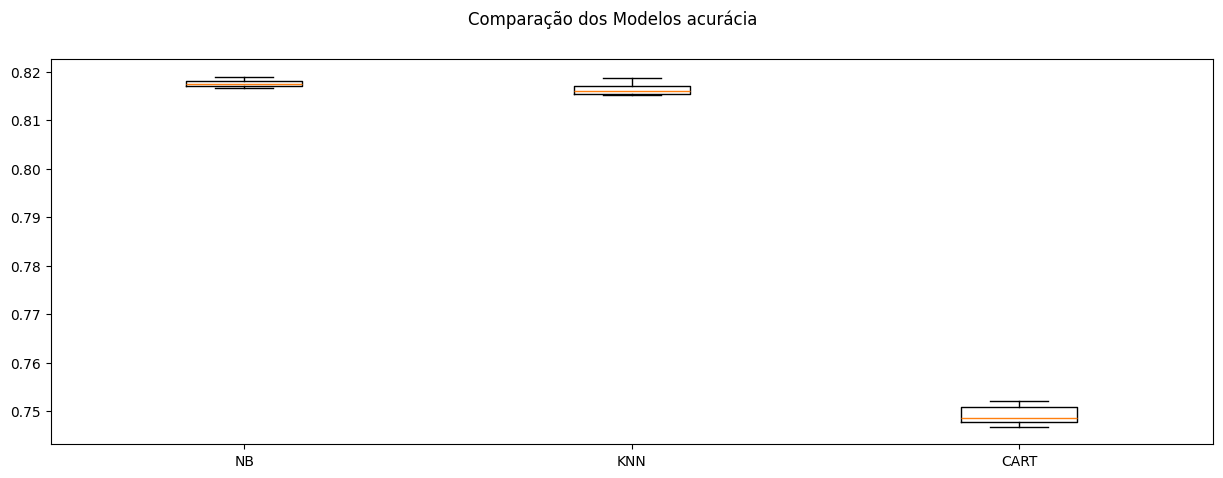

In [24]:
np.random.seed(7) # definindo uma semente global

# Lista que armazenará os modelos
models = []

# Criando os modelos e adicionando-os na lista de modelos
models.append(('NB', GaussianNB())) # mais rápido
models.append(('KNN', KNeighborsClassifier()))  # (25~50x mais lento q 'NB')
models.append(('CART', DecisionTreeClassifier()))  # (~75x mais lento q 'NB')
# models.append(('SVM', SVC(verbose=True)))  # mais lento (~2800x mais lento q 'NB')


# =====================================

print("=== Modelo: acurácia (±desvio) ===")
scoring = 'accuracy'
# Listas para armazenar os resultados
results = []
names = []

# Avaliação dos modelos
for name, model in models:
    start = time.perf_counter()
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold_default, scoring=scoring)
    end = time.perf_counter()
    results.append(cv_results)
    names.append(name)
    msg = "%s:\t%f (±%.4f) - tempo: %.3f s" % (name, cv_results.mean(), cv_results.std(), (end-start))
    print(msg)

# Boxplot de comparação dos modelos
fig = plt.figure(figsize=(15,5))
fig.suptitle('Comparação dos Modelos acurácia')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

=== Modelo: acurácia (±desvio) ===
- NB:	0.817618 (±0.0007) - tempo: 1.027 s
- KNN:	0.816262 (±0.0011) - tempo: 48.707 s
- CART:	0.749131 (±0.0018) - tempo: 69.605 s
- SVM:	0.824463 (±0.0000) - tempo: 17538.708 s

⚠️ ⚠️ ⚠️

Pelo alto tempo demandado, não sera rodado o modelo SVM, foi verificado em outros protótipos com menos dados que o modelo SVM não possui a melhor acurácia em dados balanceados.

⚠️ ⚠️ ⚠️

> **Neste caso desbalanceado, há uma grande possibilidade de estar ocorrendo uma alta acurácia pelo modelo se apegar a somente prever a categoria majoritária (`risco_dengue = 0`), principalmente pelo fato da acurácia ser muito próxima ao percentual desta classe (baixo risco:	82.45%) em relação ao dataset  !!!**



=== Modelo: balanced_accuracy (±desvio) ===
NB:	0.337119 (±0.0009) - tempo: 1.398 s
KNN:	0.422652 (±0.0024) - tempo: 68.423 s
CART:	0.445154 (±0.0032) - tempo: 85.856 s


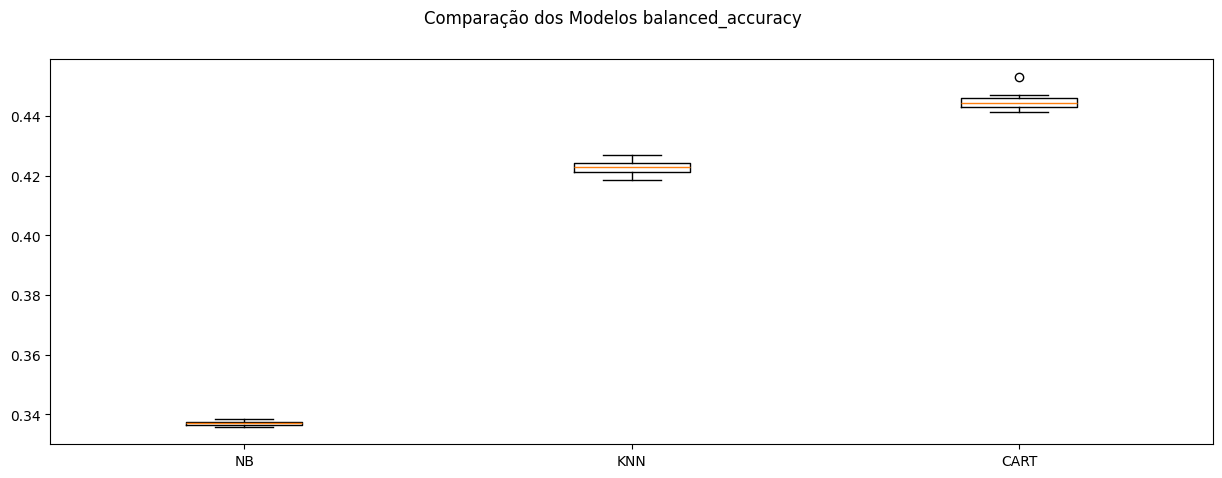



=== Modelo: f1_weighted (±desvio) ===
NB:	0.744843 (±0.0005) - tempo: 1.078 s
KNN:	0.782021 (±0.0014) - tempo: 46.409 s
CART:	0.752959 (±0.0012) - tempo: 72.155 s


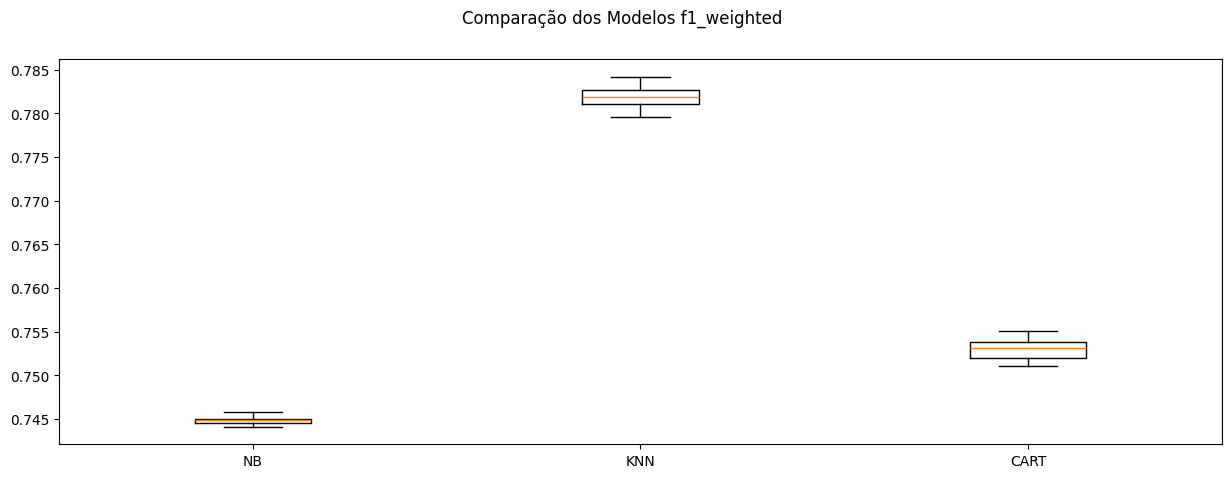

In [23]:
np.random.seed(7) # definindo uma semente global

# Lista que armazenará os modelos
models = []

# Criando os modelos e adicionando-os na lista de modelos
models.append(('NB', GaussianNB())) # mais rápido
models.append(('KNN', KNeighborsClassifier()))  # (~25x mais lento q 'NB')
models.append(('CART', DecisionTreeClassifier()))  # (~75x mais lento q 'NB')
# models.append(('SVM', SVC(verbose=True)))  # mais lento (~2800x mais lento q 'NB')

# =====================================

print("\n\n=== Modelo: balanced_accuracy (±desvio) ===")
scoring = 'balanced_accuracy'
# Listas para armazenar os resultados
results = []
names = []

# Avaliação dos modelos
for name, model in models:
    start = time.perf_counter()
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold_default, scoring=scoring)
    end = time.perf_counter()
    results.append(cv_results)
    names.append(name)
    msg = "%s:\t%f (±%.4f) - tempo: %.3f s" % (name, cv_results.mean(), cv_results.std(), (end-start))
    print(msg)

# Boxplot de comparação dos modelos
fig = plt.figure(figsize=(15,5))
fig.suptitle('Comparação dos Modelos balanced_accuracy')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()


# =====================================

print("\n\n=== Modelo: f1_weighted (±desvio) ===")
scoring = 'f1_weighted'
# Listas para armazenar os resultados
results = []
names = []

# Avaliação dos modelos
for name, model in models:
    start = time.perf_counter()
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold_default, scoring=scoring)
    end = time.perf_counter()
    results.append(cv_results)
    names.append(name)
    msg = "%s:\t%f (±%.4f) - tempo: %.3f s" % (name, cv_results.mean(), cv_results.std(), (end-start))
    print(msg)

# Boxplot de comparação dos modelos
fig = plt.figure(figsize=(15,5))
fig.suptitle('Comparação dos Modelos f1_weighted')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

> **É possivel evidênciar, pela redução de outros tipos de score como `f1_weighted`e `balanced_accuracy` que os classificadores estao se apegando a classe majoritária**

### Criação e avaliação de modelos: **Sample Simples**

Modelo: acurácia (±desvio)
NB:	0.498388 (±0.0047) - tempo: 0.386 s
KNN:	0.592418 (±0.0052) - tempo: 13.306 s
CART:	0.543471 (±0.0046) - tempo: 21.510 s


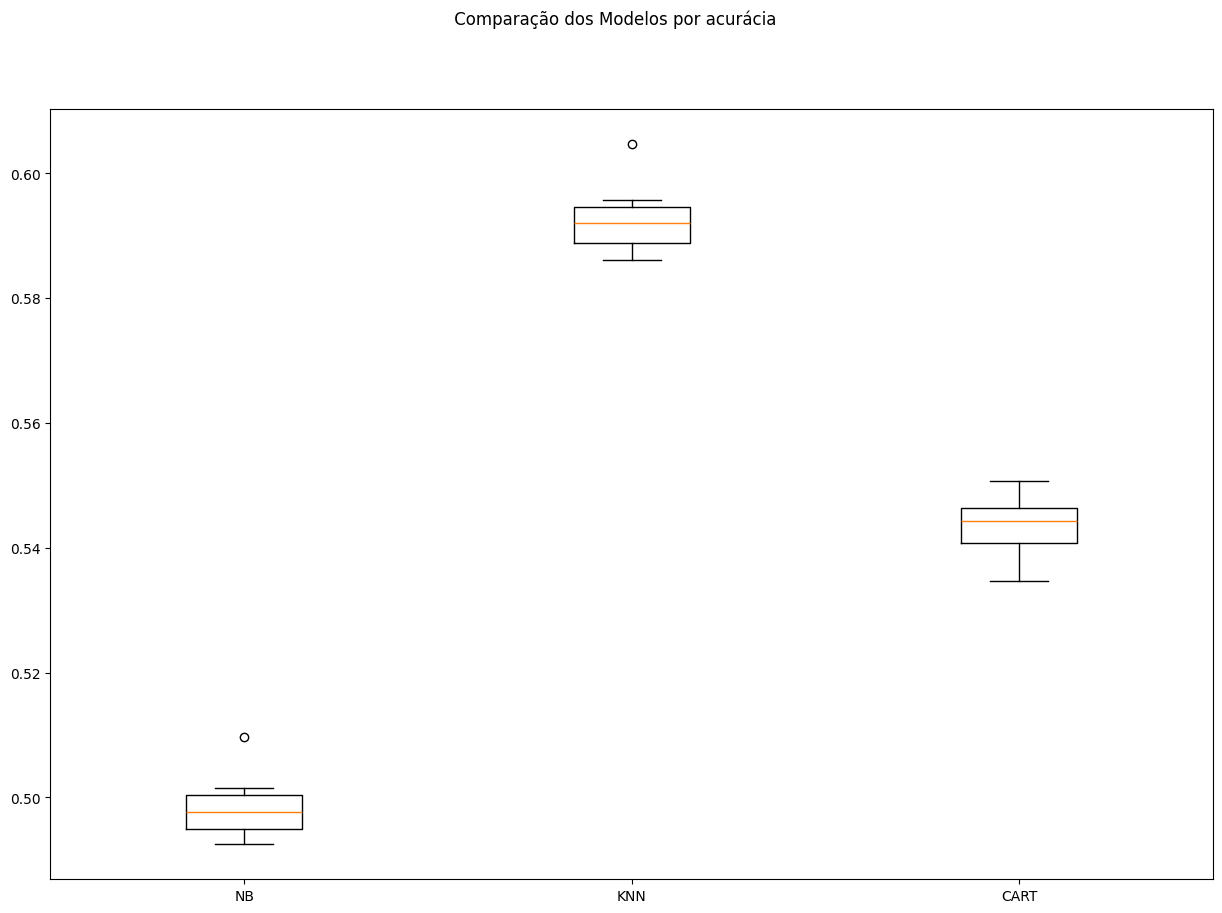


=== Modelo: f1_weighted (±desvio) ===
NB:	0.500451 (±0.0043) - tempo: 0.397 s
KNN:	0.586260 (±0.0051) - tempo: 13.281 s
CART:	0.546147 (±0.0033) - tempo: 22.453 s


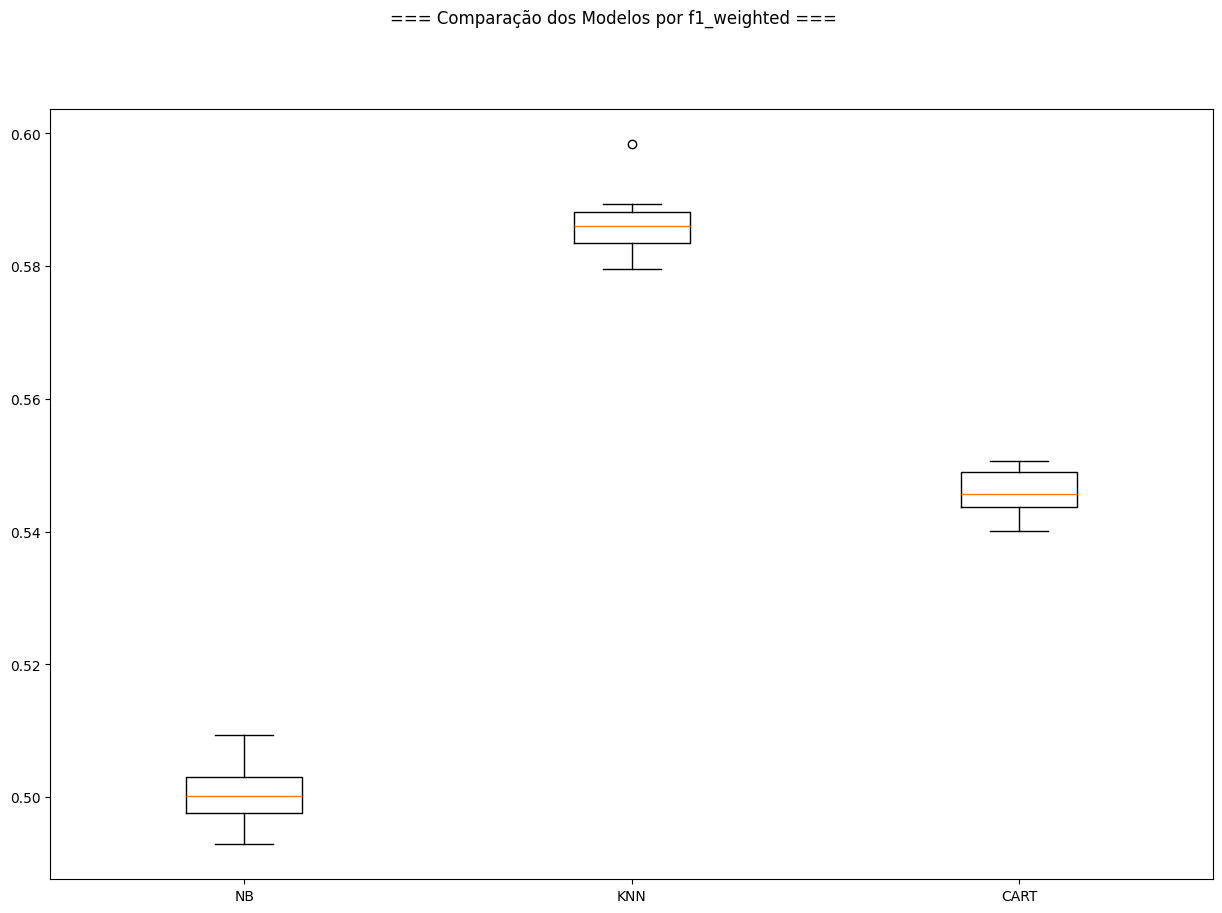

In [27]:
np.random.seed(7) # definindo uma semente global

# Lista que armazenará os modelos
models = []

# Criando os modelos e adicionando-os na lista de modelos
models.append(('NB', GaussianNB())) # mais rápido
models.append(('KNN', KNeighborsClassifier()))  # (~25x mais lento q 'NB')
models.append(('CART', DecisionTreeClassifier()))  # (~75x mais lento q 'NB')
# models.append(('SVM', SVC(verbose=True)))  # mais lento (~2800x mais lento q 'NB')

print("Modelo: acurácia (±desvio)")

# Listas para armazenar os resultados
results = []
names = []

scoring = 'accuracy'
# Avaliação dos modelos
for name, model in models:
    start = time.perf_counter()
    cv_results = cross_val_score(model, X_train_simples, y_train_simples, cv=kfold_simples, scoring=scoring)
    end = time.perf_counter()
    results.append(cv_results)
    names.append(name)
    msg = "%s:\t%f (±%.4f) - tempo: %.3f s" % (name, cv_results.mean(), cv_results.std(), (end-start))
    print(msg)

# Boxplot de comparação dos modelos
fig = plt.figure(figsize=(15,10))
fig.suptitle(' Comparação dos Modelos por acurácia')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

# ====================================

print("\n=== Modelo: f1_weighted (±desvio) ===")
# Listas para armazenar os resultados
results = []
names = []

scoring = 'f1_weighted'
# Avaliação dos modelos
for name, model in models:
    start = time.perf_counter()
    cv_results = cross_val_score(model, X_train_simples, y_train_simples, cv=kfold_simples, scoring=scoring)
    end = time.perf_counter()
    results.append(cv_results)
    names.append(name)
    msg = "%s:\t%f (±%.4f) - tempo: %.3f s" % (name, cv_results.mean(), cv_results.std(), (end-start))
    print(msg)

# Boxplot de comparação dos modelos
fig = plt.figure(figsize=(15,10))
fig.suptitle('=== Comparação dos Modelos por f1_weighted ===')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

### Criação e avaliação de modelos: **SMOTE**

Modelo com SMOTE: acurácia (±desvio)
NB:	0.464614 (±0.001900) - tempo: 3.177 s
KNN:	0.840048 (±0.001486) - tempo: 123.181 s
CART:	0.787473 (±0.001425) - tempo: 205.068 s


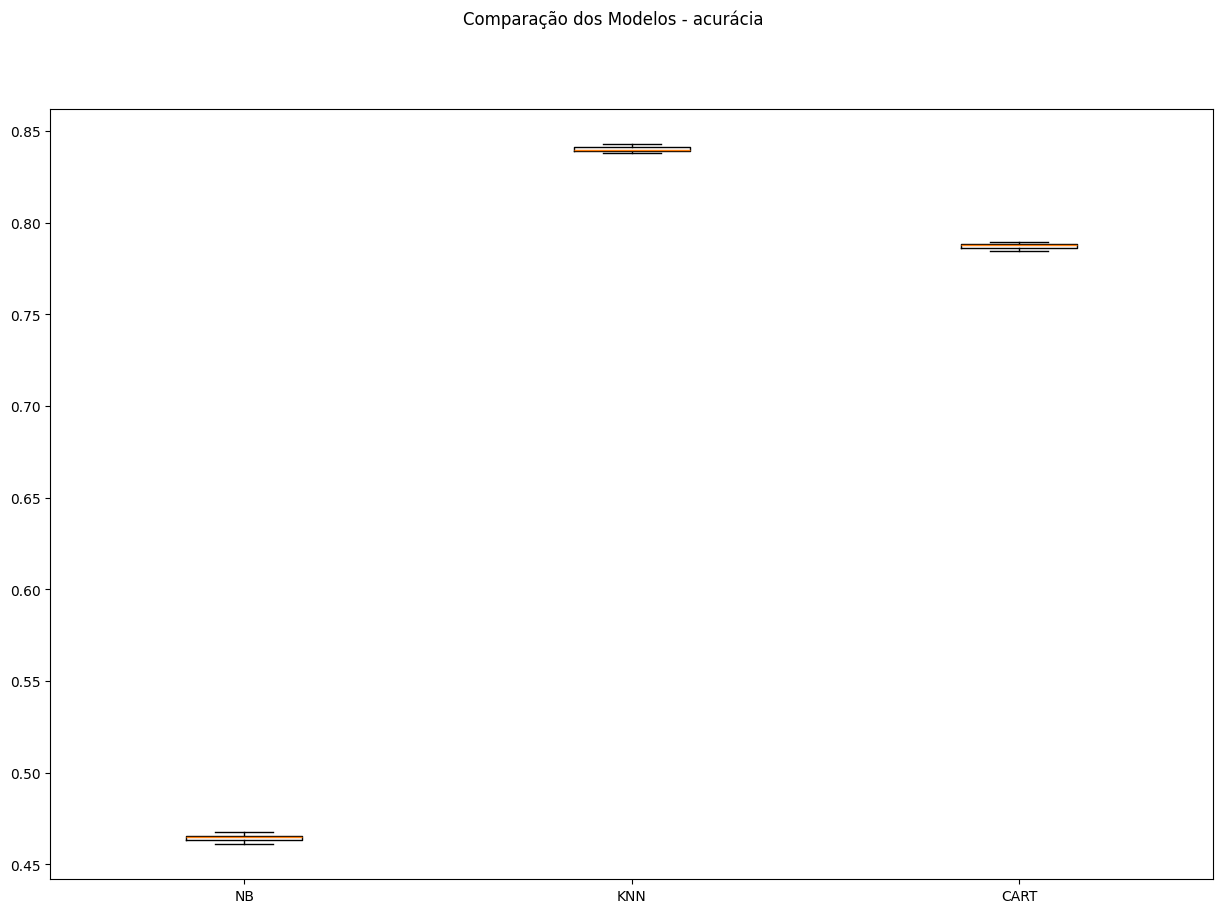


=== Modelo com SMOTE: f1_weighted (±desvio) ===
NB:	0.442483 (±0.002075) - tempo: 3.151 s
KNN:	0.836660 (±0.001499) - tempo: 120.006 s
CART:	0.787374 (±0.001356) - tempo: 204.405 s


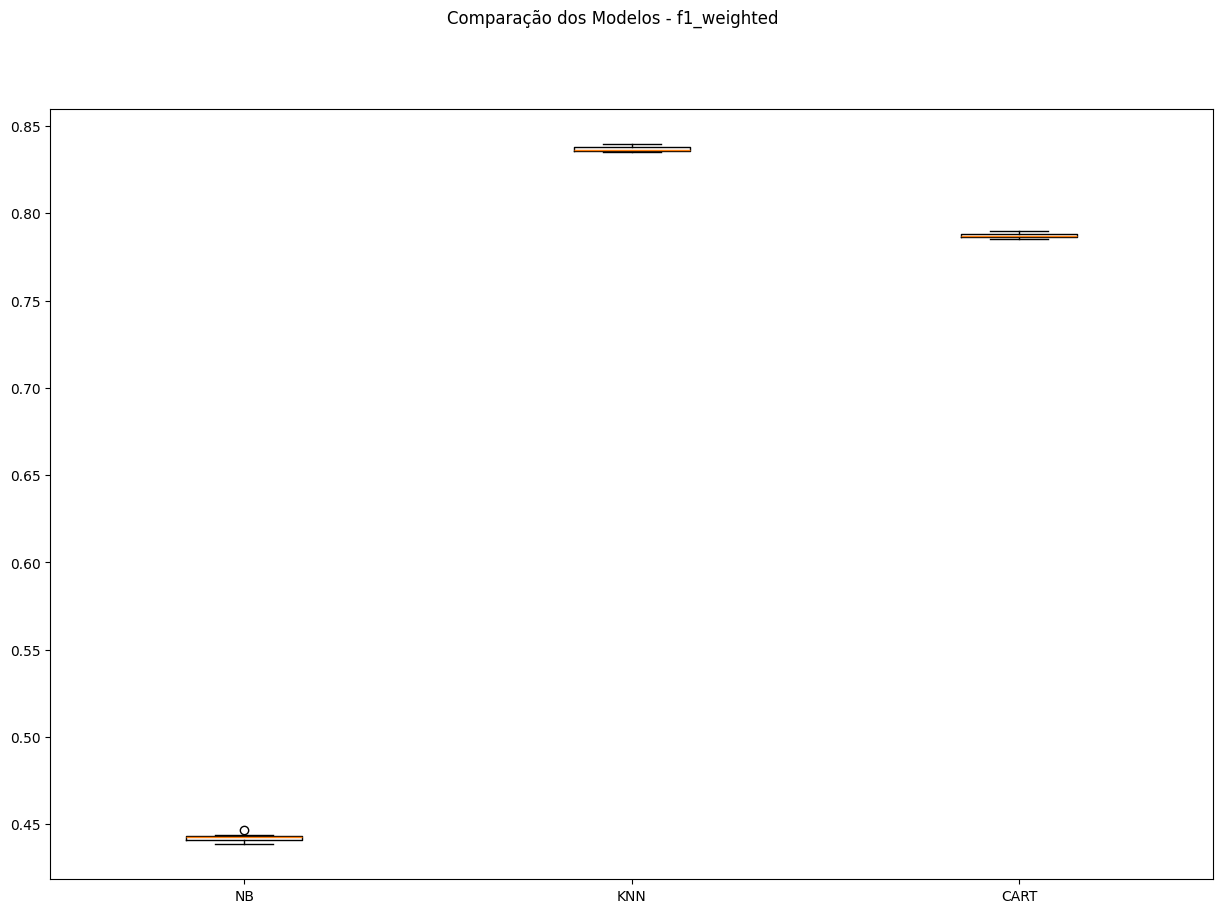

In [30]:
np.random.seed(7) # definindo uma semente global

# Lista que armazenará os modelos
models = []

# Criando os modelos e adicionando-os na lista de modelos
models.append(('NB', GaussianNB())) # mais rápido
models.append(('KNN', KNeighborsClassifier()))  # (~24x mais lento que 'NB')
models.append(('CART', DecisionTreeClassifier()))  # (~73x mais lento que 'NB')
# models.append(('SVM', SVC(verbose=True)))  # mais lento (~2790x mais lento que 'NB') # 5000+ sec

print("Modelo com SMOTE: acurácia (±desvio)")
# Listas para armazenar os resultados
results = []
names = []
scoring='accuracy'
# Avaliação dos modelos
for name, model in models:
    start = time.perf_counter()
    cv_results = cross_val_score(model, X_train_SMOTE, y_train_SMOTE, cv=kfold_SMOTE, scoring=scoring)
    end = time.perf_counter()
    results.append(cv_results)
    names.append(name)
    msg = "%s:\t%f (±%f) - tempo: %.3f s" % (name, cv_results.mean(), cv_results.std(), (end-start))
    print(msg)

# Boxplot de comparação dos modelos
fig = plt.figure(figsize=(15,10))
fig.suptitle('Comparação dos Modelos - acurácia')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

# ===========================================

print("\n=== Modelo com SMOTE: f1_weighted (±desvio) ===")
# Listas para armazenar os resultados
results = []
names = []
scoring='f1_weighted'
# Avaliação dos modelos
for name, model in models:
    start = time.perf_counter()
    cv_results = cross_val_score(model, X_train_SMOTE, y_train_SMOTE, cv=kfold_SMOTE, scoring=scoring)
    end = time.perf_counter()
    results.append(cv_results)
    names.append(name)
    msg = "%s:\t%f (±%f) - tempo: %.3f s" % (name, cv_results.mean(), cv_results.std(), (end-start))
    print(msg)

# Boxplot de comparação dos modelos
fig = plt.figure(figsize=(15,10))
fig.suptitle('Comparação dos Modelos - f1_weighted')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

### Criação e avaliação de modelos: **Near Miss**

=== Modelo com Near Miss: acurácia (±desvio) ===
NB:	0.393927 (±0.006978) - tempo: 0.384 s
KNN:	0.446398 (±0.005613) - tempo: 7.183 s
CART:	0.410360 (±0.004689) - tempo: 13.010 s


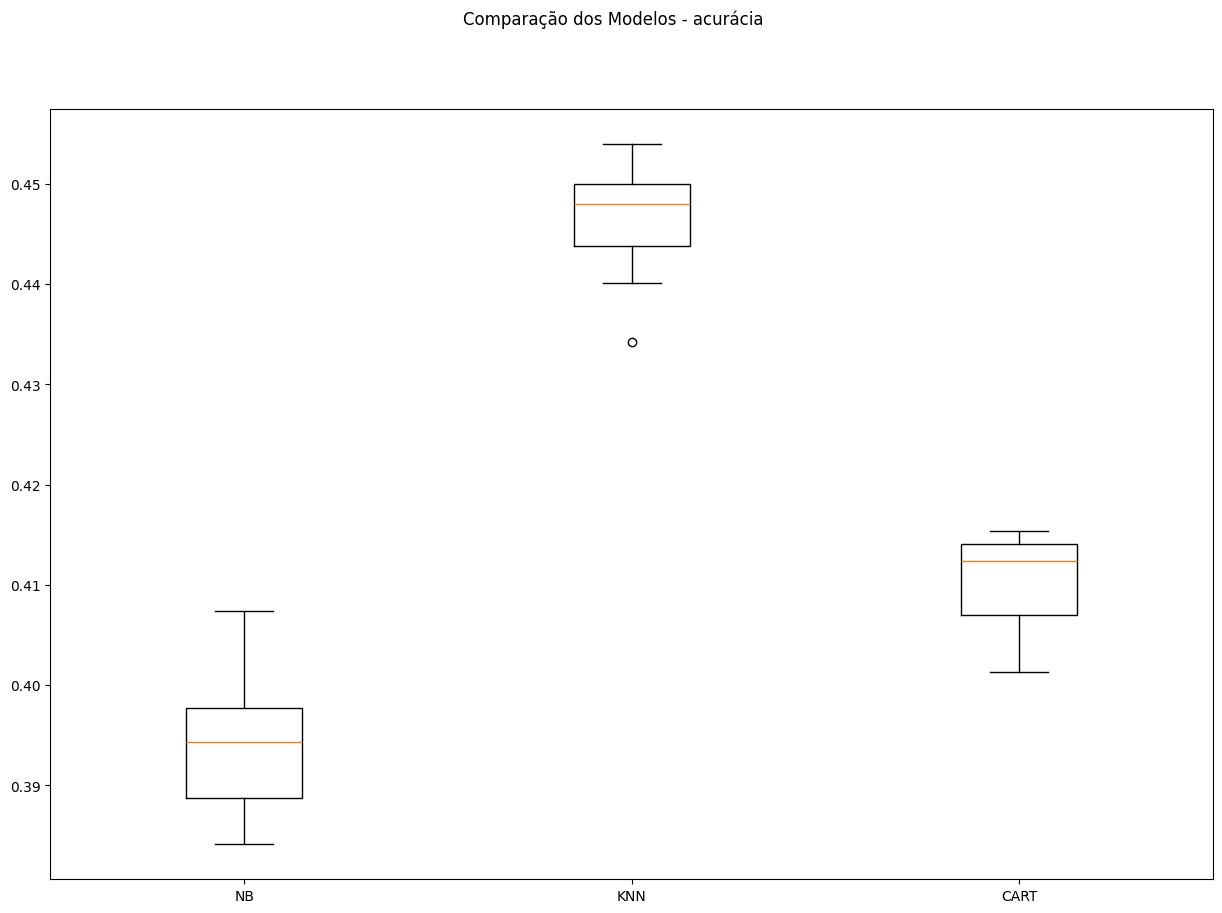



=== Modelo com Near Miss: f1_weighted (±desvio) ===
NB:	0.375697 (±0.006549) - tempo: 0.274 s
KNN:	0.435850 (±0.005363) - tempo: 8.445 s
CART:	0.409644 (±0.003630) - tempo: 13.616 s


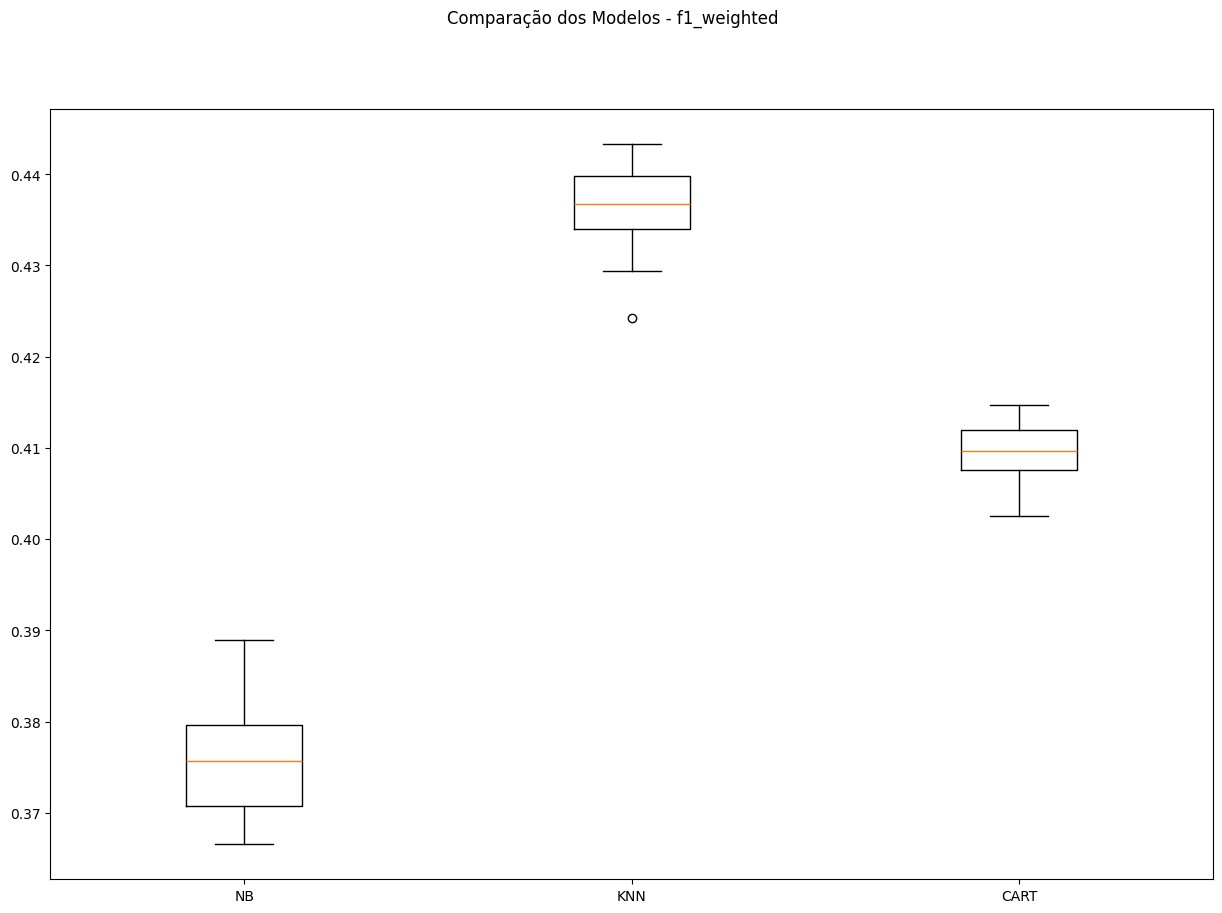

In [29]:
np.random.seed(7) # definindo uma semente global

# Lista que armazenará os modelos
models = []

# Criando os modelos e adicionando-os na lista de modelos
models.append(('NB', GaussianNB())) # mais rápido
models.append(('KNN', KNeighborsClassifier()))  # (12~25x mais lento que 'NB')
models.append(('CART', DecisionTreeClassifier()))  # (45~70x mais lento que 'NB')
# models.append(('SVM', SVC(verbose=True)))  # mais lento (1700~2700x mais lento que 'NB')

print("=== Modelo com Near Miss: acurácia (±desvio) ===")
scoring='accuracy'
# Listas para armazenar os resultados
results = []
names = []

# Avaliação dos modelos
for name, model in models:
    start = time.perf_counter()
    cv_results = cross_val_score(model, X_train_nm, y_train_nm, cv=kfold_nm, scoring=scoring)
    end = time.perf_counter()
    results.append(cv_results)
    names.append(name)
    msg = "%s:\t%f (±%f) - tempo: %.3f s" % (name, cv_results.mean(), cv_results.std(), (end-start))
    print(msg)

# Boxplot de comparação dos modelos
fig = plt.figure(figsize=(15,10))
fig.suptitle('Comparação dos Modelos - acurácia')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

# ===============================================

print("\n\n=== Modelo com Near Miss: f1_weighted (±desvio) ===")
scoring='f1_weighted'
# Listas para armazenar os resultados
results = []
names = []

# Avaliação dos modelos
for name, model in models:
    start = time.perf_counter()
    cv_results = cross_val_score(model, X_train_nm, y_train_nm, cv=kfold_nm, scoring=scoring)
    end = time.perf_counter()
    results.append(cv_results)
    names.append(name)
    msg = "%s:\t%f (±%f) - tempo: %.3f s" % (name, cv_results.mean(), cv_results.std(), (end-start))
    print(msg)

# Boxplot de comparação dos modelos
fig = plt.figure(figsize=(15,10))
fig.suptitle('Comparação dos Modelos - f1_weighted')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

#### Resumo:

=== Modelo  Linha de Base: acurácia (±desvio) ===
- NB:	0.817618 (±0.0007) - tempo: 1.052 s
- KNN:	0.816262 (±0.0011) - tempo: 58.410 s
- CART:	0.749131 (±0.0018) - tempo: 89.218 s

=== Modelo Linha de Base: f1_weighted (±desvio) ===
- NB:	0.744843 (±0.0005) - tempo: 1.078 s
- KNN:	0.782021 (±0.0014) - tempo: 46.409 s
- CART:	0.752959 (±0.0012) - tempo: 72.155 s

---

=== Modelo com Sample Simples: acurácia (±desvio) ===
- NB:	0.498388 (±0.0047) - tempo: 0.386 s
- KNN:	0.592418 (±0.0052) - tempo: 13.306 s
- CART:	0.543471 (±0.0046) - tempo: 21.510 s

=== Modelo com Sample Simples: f1_weighted (±desvio) ===
- NB:	0.500451 (±0.0043) - tempo: 0.397 s
- KNN:	0.586260 (±0.0051) - tempo: 13.281 s
- CART:	0.546147 (±0.0033) - tempo: 22.453 s

---

Modelo com SMOTE: acurácia (±desvio)
- NB:	0.464614 (±0.001900) - tempo: 3.177 s
- KNN:	0.840048 (±0.001486) - tempo: 123.181 s
- CART:	0.787473 (±0.001425) - tempo: 205.068 s

=== Modelo com SMOTE: f1_weighted (±desvio) ===
- NB:	0.442483 (±0.002075) - tempo: 3.151 s
- KNN:	0.836660 (±0.001499) - tempo: 120.006 s
- CART:	0.787374 (±0.001356) - tempo: 204.405 s

---

=== Modelo com Near Miss: acurácia (±desvio) ===
- NB:	0.393927 (±0.006978) - tempo: 0.384 s
- KNN:	0.446398 (±0.005613) - tempo: 7.183 s
- CART:	0.410360 (±0.004689) - tempo: 13.010 s

=== Modelo com Near Miss: f1_weighted (±desvio) ===
- NB:	0.375697 (±0.006549) - tempo: 0.274 s
- KNN:	0.435850 (±0.005363) - tempo: 8.445 s
- CART:	0.409644 (±0.003630) - tempo: 13.616 s

___
### Criação e avaliação de modelos: dados padronizados e normalizados

#### Dados sem balanceamento (linha base) padronizados e normalizados

NB-orig:	0.745 (±0.00046) - tempo: 7.421 ms
KNN-orig:	0.782 (±0.00138) - tempo: 42.386 ms
CART-orig:	0.753 (±0.00130) - tempo: 61.754 ms
NB-padr:	0.745 (±0.00046) - tempo: 1.560 ms
KNN-padr:	0.780 (±0.00169) - tempo: 44.172 ms
CART-padr:	0.753 (±0.00175) - tempo: 56.807 ms
NB-norm:	0.745 (±0.00046) - tempo: 1.973 ms
KNN-norm:	0.783 (±0.00149) - tempo: 46.191 ms
CART-norm:	0.754 (±0.00164) - tempo: 56.959 ms


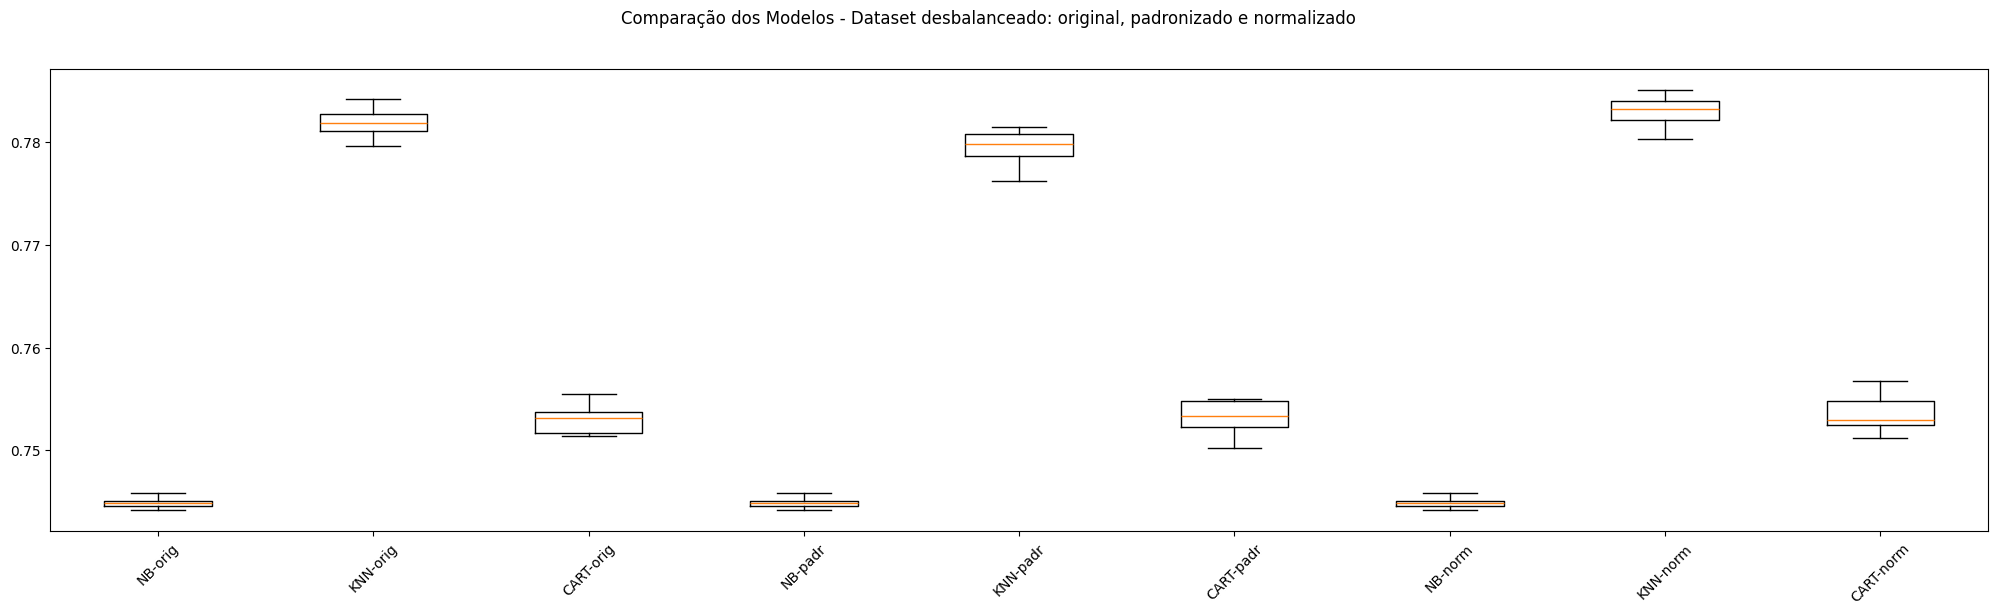

In [32]:
np.random.seed(7) # definindo uma semente global para este bloco

# Listas para armazenar os armazenar os pipelines e os resultados para todas as visões do dataset
pipelines = []
results = []
names = []


# Criando os elementos do pipeline

# Algoritmos que serão utilizados
knn = ('KNN', KNeighborsClassifier())
cart = ('CART', DecisionTreeClassifier())
naive_bayes = ('NB', GaussianNB())
# svm = ('SVM', SVC())

# Transformações que serão utilizadas
standard_scaler = ('StandardScaler', StandardScaler())
min_max_scaler = ('MinMaxScaler', MinMaxScaler())


# Montando os pipelines

# Dataset original
pipelines.append(('NB-orig', Pipeline([naive_bayes])))
pipelines.append(('KNN-orig', Pipeline([knn])))
pipelines.append(('CART-orig', Pipeline([cart])))
# pipelines.append(('SVM-orig', Pipeline([svm])))

# Dataset Padronizado
pipelines.append(('NB-padr', Pipeline([standard_scaler, naive_bayes])))
pipelines.append(('KNN-padr', Pipeline([standard_scaler, knn])))
pipelines.append(('CART-padr', Pipeline([standard_scaler, cart])))
# pipelines.append(('SVM-padr', Pipeline([standard_scaler, svm])))

# Dataset Normalizado
pipelines.append(('NB-norm', Pipeline([min_max_scaler, naive_bayes])))
pipelines.append(('KNN-norm', Pipeline([min_max_scaler, knn])))
pipelines.append(('CART-norm', Pipeline([min_max_scaler, cart])))
# pipelines.append(('SVM-norm', Pipeline([min_max_scaler, svm])))

# Executando os pipelines
for name, model in pipelines:
    start = time.perf_counter()
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold_default, scoring=scoring, n_jobs=4)
    end = time.perf_counter()
    results.append(cv_results)
    names.append(name)
    msg = "%s:\t%.3f (±%.5f) - tempo: %.3f ms" % (name, cv_results.mean(), cv_results.std(), (end-start))
    print(msg)

# Boxplot de comparação dos modelos
fig = plt.figure(figsize=(25,6))
fig.suptitle('Comparação dos Modelos - Dataset desbalanceado: original, padronizado e normalizado')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names, rotation=45)
plt.show()

#### Dados com balanceamento Sample Simples padronizados e normalizados

NB-orig-SampleSimples:		0.500 (±0.00431) - tempo: 0.445 ms
KNN-orig-SampleSimples:		0.586 (±0.00506) - tempo: 12.778 ms
CART-orig-SampleSimples:		0.545 (±0.00429) - tempo: 21.237 ms
NB-padr-SampleSimples:		0.500 (±0.00431) - tempo: 0.619 ms
KNN-padr-SampleSimples:		0.579 (±0.00348) - tempo: 14.231 ms
CART-padr-SampleSimples:		0.546 (±0.00334) - tempo: 21.240 ms
NB-norm-SampleSimples:		0.500 (±0.00431) - tempo: 0.738 ms
KNN-norm-SampleSimples:		0.589 (±0.00416) - tempo: 17.674 ms
CART-norm-SampleSimples:		0.546 (±0.00371) - tempo: 21.159 ms


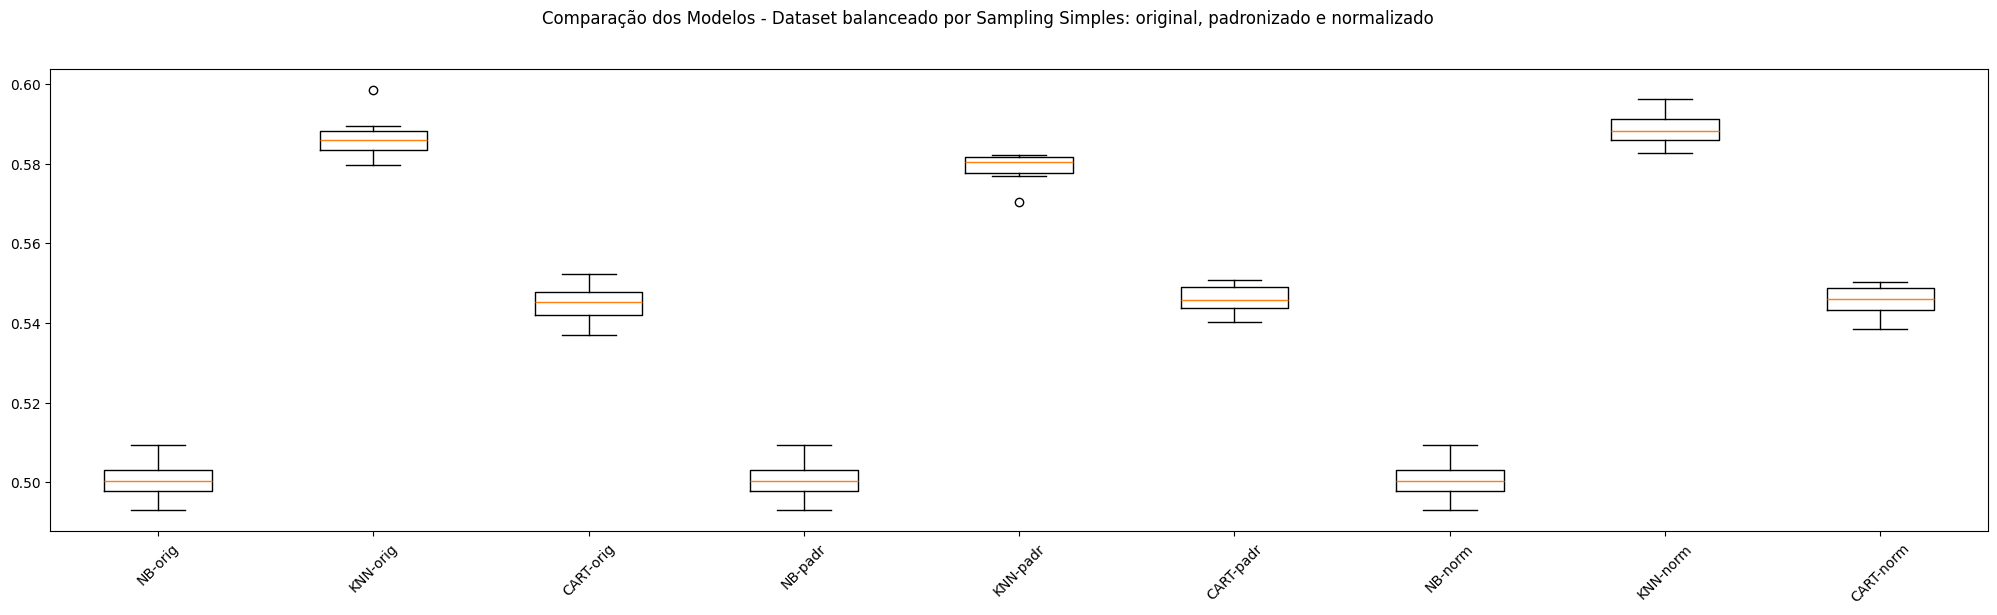

In [33]:
np.random.seed(7) # definindo uma semente global para este bloco

# Listas para armazenar os armazenar os pipelines e os resultados para todas as visões do dataset
pipelines = []
results = []
names = []


# Criando os elementos do pipeline

# Algoritmos que serão utilizados
knn = ('KNN', KNeighborsClassifier())
cart = ('CART', DecisionTreeClassifier())
naive_bayes = ('NB', GaussianNB())
# svm = ('SVM', SVC())

# Transformações que serão utilizadas
standard_scaler = ('StandardScaler', StandardScaler())
min_max_scaler = ('MinMaxScaler', MinMaxScaler())


# Montando os pipelines

# Dataset original
pipelines.append(('NB-orig', Pipeline([naive_bayes])))
pipelines.append(('KNN-orig', Pipeline([knn])))
pipelines.append(('CART-orig', Pipeline([cart])))
# pipelines.append(('SVM-orig', Pipeline([svm])))

# Dataset Padronizado
pipelines.append(('NB-padr', Pipeline([standard_scaler, naive_bayes])))
pipelines.append(('KNN-padr', Pipeline([standard_scaler, knn])))
pipelines.append(('CART-padr', Pipeline([standard_scaler, cart])))
# pipelines.append(('SVM-padr', Pipeline([standard_scaler, svm])))

# Dataset Normalizado
pipelines.append(('NB-norm', Pipeline([min_max_scaler, naive_bayes])))
pipelines.append(('KNN-norm', Pipeline([min_max_scaler, knn])))
pipelines.append(('CART-norm', Pipeline([min_max_scaler, cart])))
# pipelines.append(('SVM-norm', Pipeline([min_max_scaler, svm])))

# Executando os pipelines
for name, model in pipelines:
    start = time.perf_counter()
    cv_results = cross_val_score(model, X_train_simples, y_train_simples, cv=kfold_simples, scoring=scoring)
    end = time.perf_counter()
    results.append(cv_results)
    names.append(name)
    msg = "%s-SampleSimples:\t\t%.3f (±%.5f) - tempo: %.3f ms" % (name, cv_results.mean(), cv_results.std(), (end-start))
    print(msg)

# Boxplot de comparação dos modelos
fig = plt.figure(figsize=(25,6))
fig.suptitle('Comparação dos Modelos - Dataset balanceado por Sampling Simples: original, padronizado e normalizado')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names, rotation=45)
plt.show()

#### Dados com balanceamento SMOTE padronizados e normalizados

NB-orig-SMOTE:		0.442 (±0.00208) - tempo: 2.912 s
KNN-orig-SMOTE:		0.837 (±0.00150) - tempo: 119.069 s
CART-orig-SMOTE:		0.787 (±0.00142) - tempo: 205.538 s
NB-padr-SMOTE:		0.442 (±0.00208) - tempo: 4.008 s
KNN-padr-SMOTE:		0.804 (±0.00163) - tempo: 135.082 s
CART-padr-SMOTE:		0.787 (±0.00155) - tempo: 206.550 s
NB-norm-SMOTE:		0.442 (±0.00208) - tempo: 3.423 s
KNN-norm-SMOTE:		0.804 (±0.00130) - tempo: 163.466 s
CART-norm-SMOTE:		0.787 (±0.00115) - tempo: 208.163 s


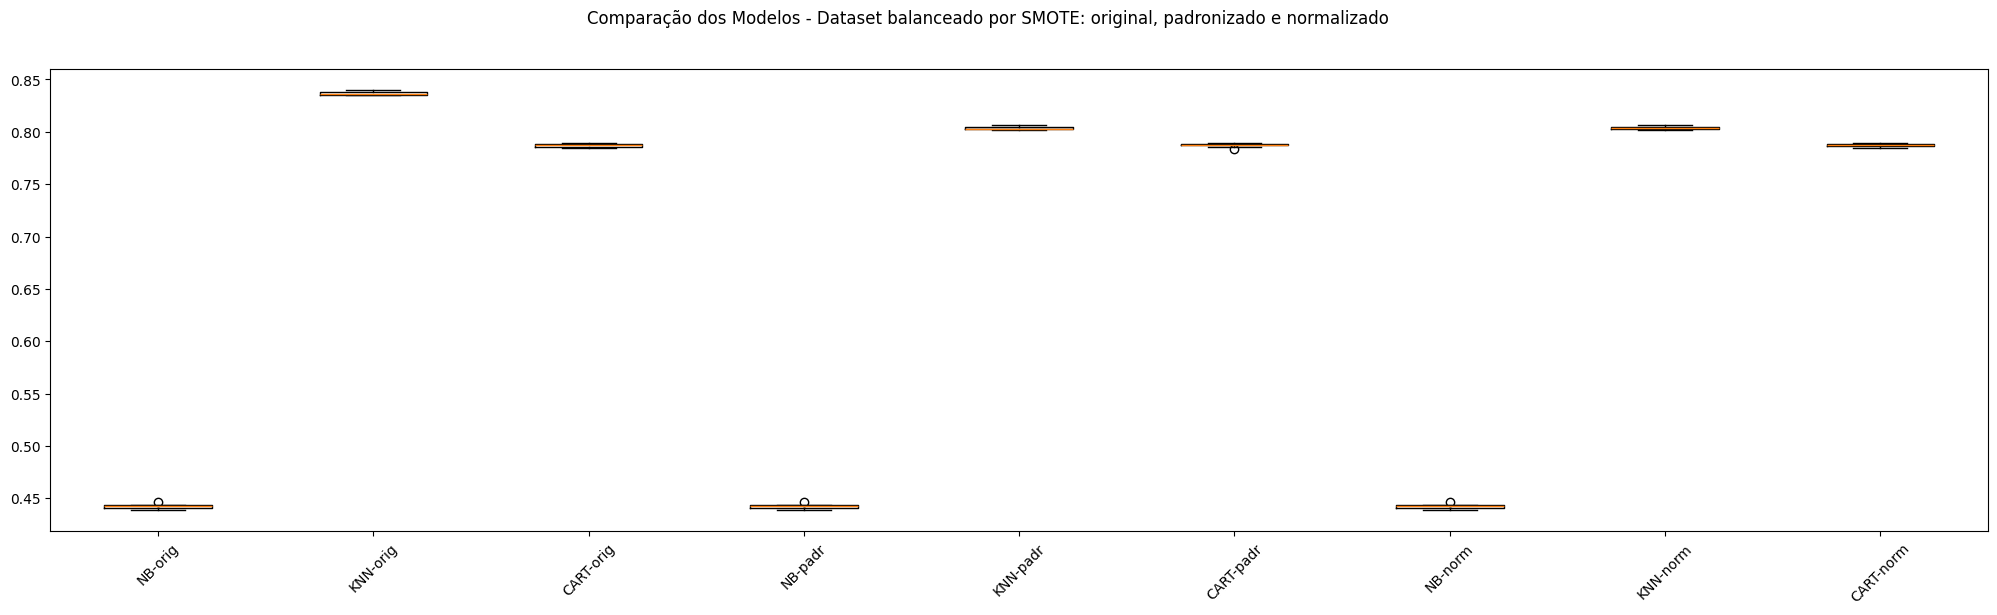

In [34]:
np.random.seed(7) # definindo uma semente global para este bloco

# Listas para armazenar os armazenar os pipelines e os resultados para todas as visões do dataset
pipelines = []
results = []
names = []


# Criando os elementos do pipeline

# Algoritmos que serão utilizados
knn = ('KNN', KNeighborsClassifier())
cart = ('CART', DecisionTreeClassifier())
naive_bayes = ('NB', GaussianNB())
svm = ('SVM', SVC())

# Transformações que serão utilizadas
standard_scaler = ('StandardScaler', StandardScaler())
min_max_scaler = ('MinMaxScaler', MinMaxScaler())


# Montando os pipelines

# Dataset original
pipelines.append(('NB-orig', Pipeline([naive_bayes])))
pipelines.append(('KNN-orig', Pipeline([knn])))
pipelines.append(('CART-orig', Pipeline([cart])))
# pipelines.append(('SVM-orig', Pipeline([svm])))

# Dataset Padronizado
pipelines.append(('NB-padr', Pipeline([standard_scaler, naive_bayes])))
pipelines.append(('KNN-padr', Pipeline([standard_scaler, knn])))
pipelines.append(('CART-padr', Pipeline([standard_scaler, cart])))
# pipelines.append(('SVM-padr', Pipeline([standard_scaler, svm])))

# Dataset Normalizado
pipelines.append(('NB-norm', Pipeline([min_max_scaler, naive_bayes])))
pipelines.append(('KNN-norm', Pipeline([min_max_scaler, knn])))
pipelines.append(('CART-norm', Pipeline([min_max_scaler, cart])))
# pipelines.append(('SVM-norm', Pipeline([min_max_scaler, svm])))

# Executando os pipelines
for name, model in pipelines:
    start = time.perf_counter()
    cv_results = cross_val_score(model, X_train_SMOTE, y_train_SMOTE, cv=kfold_SMOTE, scoring=scoring)
    end = time.perf_counter()
    results.append(cv_results)
    names.append(name)
    msg = "%s-SMOTE:\t\t%.3f (±%.5f) - tempo: %.3f s" % (name, cv_results.mean(), cv_results.std(), (end-start))
    print(msg)

# Boxplot de comparação dos modelos
fig = plt.figure(figsize=(25,6))
fig.suptitle('Comparação dos Modelos - Dataset balanceado por SMOTE: original, padronizado e normalizado')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names, rotation=45)
plt.show()

#### Dados com balanceamento Near Miss padronizados e normalizados

NB-orig-NearMiss:	0.376 (±0.00655) - tempo: 6.227 ms
KNN-orig-NearMiss:	0.436 (±0.00536) - tempo: 7.581 ms
CART-orig-NearMiss:	0.408 (±0.00428) - tempo: 9.659 ms
NB-padr-NearMiss:	0.376 (±0.00655) - tempo: 1.201 ms
KNN-padr-NearMiss:	0.435 (±0.00398) - tempo: 7.948 ms
CART-padr-NearMiss:	0.410 (±0.00503) - tempo: 11.266 ms
NB-norm-NearMiss:	0.376 (±0.00655) - tempo: 0.465 ms
KNN-norm-NearMiss:	0.439 (±0.00468) - tempo: 7.409 ms
CART-norm-NearMiss:	0.409 (±0.00485) - tempo: 10.853 ms


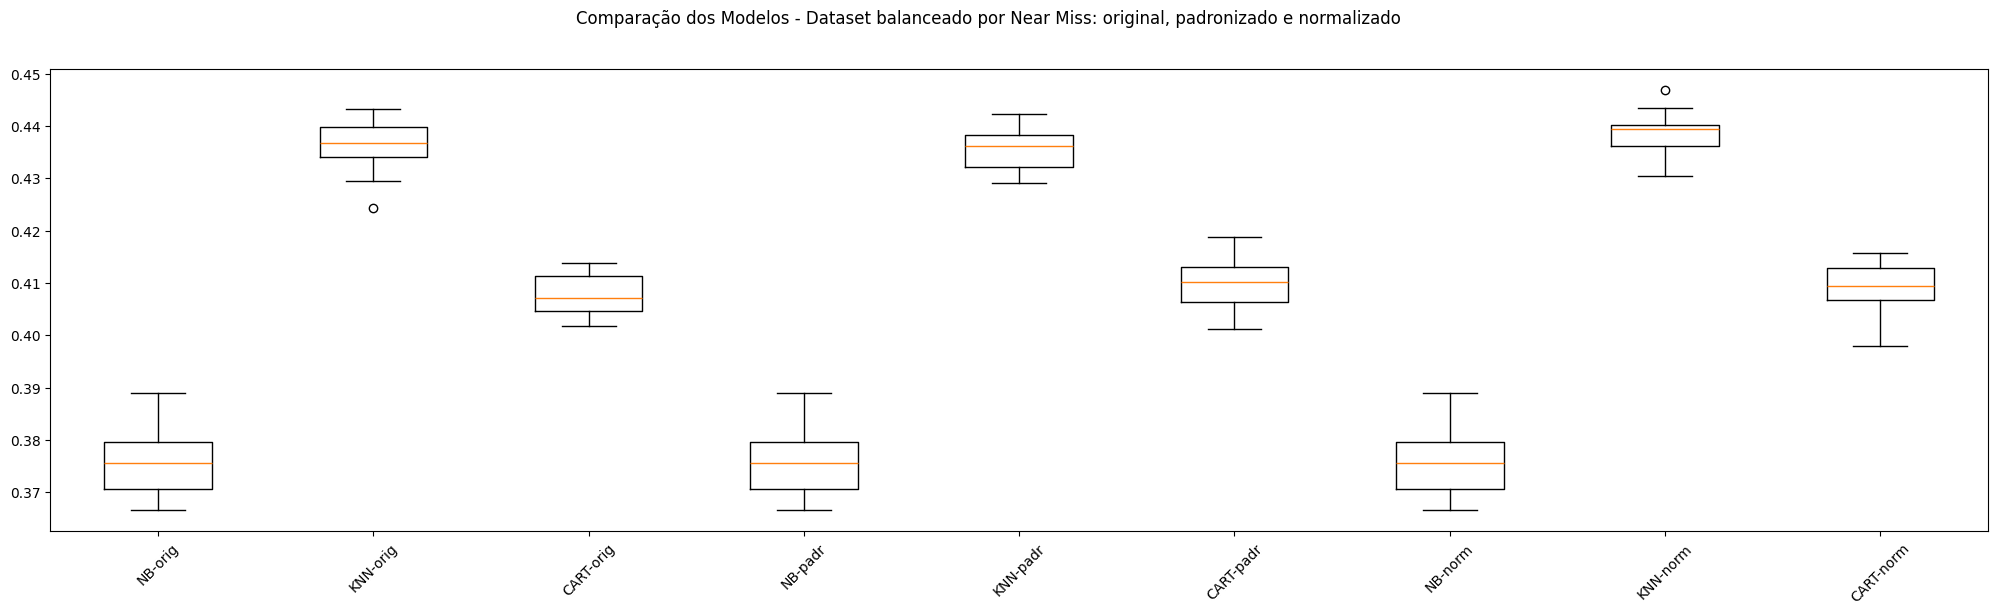

In [35]:
np.random.seed(7) # definindo uma semente global para este bloco

# Listas para armazenar os armazenar os pipelines e os resultados para todas as visões do dataset
pipelines = []
results = []
names = []


# Criando os elementos do pipeline

# Algoritmos que serão utilizados
knn = ('KNN', KNeighborsClassifier())
cart = ('CART', DecisionTreeClassifier())
naive_bayes = ('NB', GaussianNB())
# svm = ('SVM', SVC())

# Transformações que serão utilizadas
standard_scaler = ('StandardScaler', StandardScaler())
min_max_scaler = ('MinMaxScaler', MinMaxScaler())


# Montando os pipelines

# Dataset original
pipelines.append(('NB-orig', Pipeline([naive_bayes])))
pipelines.append(('KNN-orig', Pipeline([knn])))
pipelines.append(('CART-orig', Pipeline([cart])))
# pipelines.append(('SVM-orig', Pipeline([svm])))

# Dataset Padronizado
pipelines.append(('NB-padr', Pipeline([standard_scaler, naive_bayes])))
pipelines.append(('KNN-padr', Pipeline([standard_scaler, knn])))
pipelines.append(('CART-padr', Pipeline([standard_scaler, cart])))
# pipelines.append(('SVM-padr', Pipeline([standard_scaler, svm])))

# Dataset Normalizado
pipelines.append(('NB-norm', Pipeline([min_max_scaler, naive_bayes])))
pipelines.append(('KNN-norm', Pipeline([min_max_scaler, knn])))
pipelines.append(('CART-norm', Pipeline([min_max_scaler, cart])))
# pipelines.append(('SVM-norm', Pipeline([min_max_scaler, svm])))

# Executando os pipelines
for name, model in pipelines:
    start = time.perf_counter()
    cv_results = cross_val_score(model, X_train_nm, y_train_nm, cv=kfold_nm, scoring=scoring, n_jobs=4)
    end = time.perf_counter()
    results.append(cv_results)
    names.append(name)
    msg = "%s-NearMiss:\t%.3f (±%.5f) - tempo: %.3f ms" % (name, cv_results.mean(), cv_results.std(), (end-start))
    print(msg)

# Boxplot de comparação dos modelos
fig = plt.figure(figsize=(25,6))
fig.suptitle('Comparação dos Modelos - Dataset balanceado por Near Miss: original, padronizado e normalizado')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names, rotation=45)
plt.show()

> ### **Se verifica uma maior acurácia e um maior *f1_weighted score* com as seguintes condições:**
- Modelo KNN,
- Balanceamento SMOTE,
- Dados originais.

___
### Otimização dos hiperparâmetros KNN

In [36]:
# Todos parametros KNN: (parametro: valor padrão)
{k: v for k, v in KNeighborsClassifier().get_params().items()}

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 5,
 'p': 2,
 'weights': 'uniform'}

#### Dados com balanceamento SMOTE

In [ ]:
# Tuning do KNN com balanceamento SMOTE

np.random.seed(7) # definindo uma semente global para este bloco

pipelines = []

# Definindo os componentes do pipeline KNN
knn = ('KNN', KNeighborsClassifier())
standard_scaler = ('StandardScaler', StandardScaler())
min_max_scaler = ('MinMaxScaler', MinMaxScaler())

pipelines.append(('knn-orig', Pipeline(steps=[knn])))
pipelines.append(('knn-padr', Pipeline(steps=[standard_scaler, knn])))
pipelines.append(('knn-norm', Pipeline(steps=[min_max_scaler, knn])))

param_grid = {
    'KNN__n_neighbors': [1,3,5,7,9,11,13,15,17,19,21],
    'KNN__weights': ['uniform', 'distance'],
    'KNN__metric': ["euclidean", "manhattan", "minkowski"],
}

# Prepara e executa o GridSearchCV
for name, model in pipelines:
    start = time.perf_counter()
    grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold_SMOTE, verbose=1, n_jobs=4)
    grid.fit(X_train_SMOTE, y_train_SMOTE)
    end = time.perf_counter()
    # imprime a melhor configuração
    print("%s - Melhor: %.5f usando %s - tempo: %.3f s" % (name, grid.best_score_, grid.best_params_, (end-start)))

Fitting 10 folds for each of 66 candidates, totalling 660 fits
knn-orig - Melhor: 0.88561 usando {'KNN__metric': 'manhattan', 'KNN__n_neighbors': 1, 'KNN__weights': 'uniform'} - tempo: 1362.081 s
Fitting 10 folds for each of 66 candidates, totalling 660 fits
knn-padr - Melhor: 0.85830 usando {'KNN__metric': 'euclidean', 'KNN__n_neighbors': 1, 'KNN__weights': 'uniform'} - tempo: 1739.514 s
Fitting 10 folds for each of 66 candidates, totalling 660 fits
knn-norm - Melhor: 0.85703 usando {'KNN__metric': 'euclidean', 'KNN__n_neighbors': 1, 'KNN__weights': 'uniform'} - tempo: 2052.498 s


## Finalização do Modelo

> Melhores hiperparâmetros do KNN
- 'KNN__metric': 'manhattan',
- 'KNN__n_neighbors': 1,
- 'KNN__weights': 'uniform'

In [37]:
# Avaliação do melhor modelo com o conjunto de testes balanceado por SMOTE

# Preparação do modelo KNN-ORIG
model_knn = KNeighborsClassifier(metric='manhattan', n_neighbors=1, weights='uniform')
model_knn.fit(X_train_SMOTE, y_train_SMOTE)
display(model_knn)
# Estimativa da acurácia no conjunto de teste
predictions = model_knn.predict(X_test_SMOTE)
print("Acurácia:",accuracy_score(y_test_SMOTE, predictions))
# print("f1_weighted:",f1_score(y_test_SMOTE, predictions, average=None))
classes = np.unique(y_test_SMOTE)
print("f1_weighted scores:")
scores = f1_score(y_test_SMOTE, predictions, average=None)
for classe, valor in zip(classes, scores):
    print(f"Score risco dengue = {classe}: {valor}")

KNeighborsClassifier(metric='manhattan', n_neighbors=1)

Acurácia: 0.8899877233665258
f1_weighted scores:
Score risco dengue = 0: 0.8429021423226188
Score risco dengue = 1: 0.8876813748810657
Score risco dengue = 2: 0.9334102396745647


> ### Se percebe um alta acurácia e também *f1_score* de todas as categorias da coluna target, e por coincidência, aumentando o score conforme a gravidade do risco, e portanto, a importância das classes!!!

___
## Exportação do modelo para arquivo.pkl

In [38]:
# Salvando o modelo
model = model_knn
model_filename = 'knn_model_smote_min.pkl'
with open(model_filename, 'wb') as file:
    pickle.dump(model, file)

In [39]:
# Salvando X_test e y_test
X_test_df = pd.DataFrame(X_test_SMOTE, columns=dataset.columns[:-1])
y_test_df = pd.DataFrame(y_test_SMOTE, columns=[dataset.columns[-1]])
combined_df = pd.concat([X_test_df, y_test_df], axis=1)

# Salvando os DataFrames em arquivos CSV
X_test_df.to_csv("X_test_dataset_dengue.csv", index=False)
y_test_df.to_csv("y_test_dataset_dengue.csv", index=False)
combined_df.to_csv("test_dataset_dengue.csv", index=False)


## Simulando a aplicação do modelo em dados não vistos

In [40]:
# Novos dados de anos não treinados (casos 0, 1 e 2)
data = {'week':  [5, 4, 15],
        'temp_min': [21.9384, 22.556443, 18.065386],
        'temp_med': [24.260957, 25.226557, 21.480171],
        'temp_max': [27.840286, 28.482371, 25.546371],
        'precip_med': [29.4413, 13.8368, 12.292],
        'rel_humid_med': [89.818057, 83.248557, 80.052214],
        'thermal_range': [5.901886, 5.925929, 7.480986],
        'rainy_days': [7, 7, 7],
        }

atributos = ['week', 'temp_min', 'temp_med', 'temp_max', 'precip_med', 'rel_humid_med', 'thermal_range', 'rainy_days']
entrada = pd.DataFrame(data, columns=atributos)

array_entrada = entrada.values
# Dados de entrada Originais
X_entrada = array_entrada[:,0:9].astype(float)

In [41]:
# Predição KNN de classes dos dados de entrada
saidas_knn = model_knn.predict(X_entrada)
print(saidas_knn)

[0 1 2]
